## Imports

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import time

from sklearn import metrics

import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer, PowerTransformer, Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import pickle

## Functions

In [13]:
def IQR(target):
    
    IQR = target.quantile(0.75) - target.quantile(0.25)
    
    return IQR

## Data 

In [14]:
#3x28x28 matrix of numbers images
with open('train-images.idx3-ubyte','rb') as f:
    magic, size  = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data_images  = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data_images  = data_images.reshape((size, nrows, ncols))
    data_images  = data_images[8:]

#labels from the images previously loaded
with open('train-labels.idx1-ubyte','rb') as f:
    magic, size  = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data_labels  = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>')).astype('str')

## Data exploration

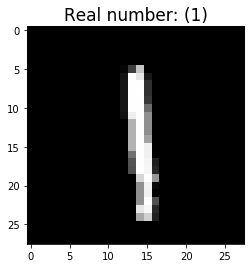

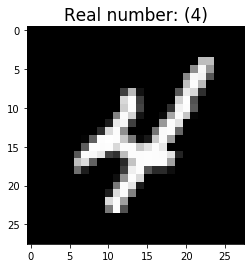

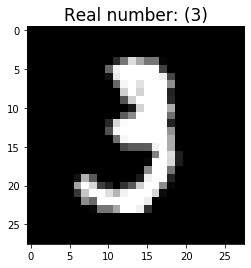

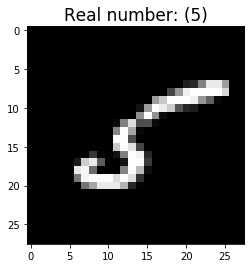

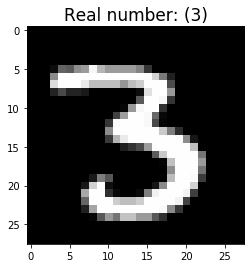

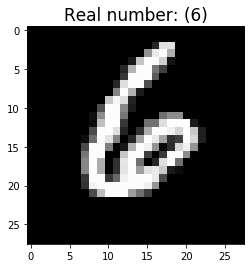

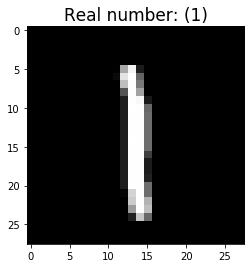

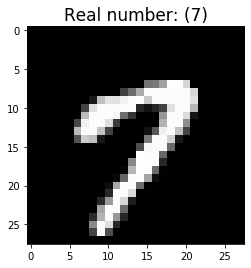

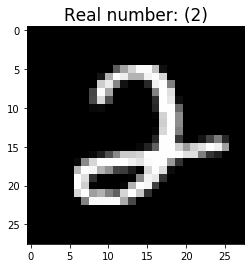

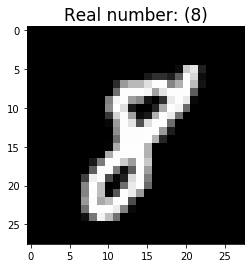

In [15]:
# first 10 images plotting
for i in range(10):
    plt.imshow(data_images[i,:,:], cmap='gray')
    plt.title(f'Real number: ({data_labels[i]})', fontsize=17)
    plt.show()

In [16]:
# dataframe with the count of unique values in the images
value, count     = np.unique(data_images, return_counts=True)
data_images_count = pd.DataFrame({'value':value, 'count':count})
data_images_count = data_images_count.sort_values(by=['count'],ascending=False)

data_images_count.head()

,value,count
0,0,38040753
253,253,1513048
254,254,801539
252,252,653659
255,255,314266


In [17]:
# I want to know the distribution of values that ares distinct to zero
data_images_NZ       = data_images_count*1
data_images_NZ       = data_images_count.loc[value>0]
data_images_NZ       = data_images_NZ['value'].repeat(data_images_NZ['count'])

data_images_NZ_mean  = data_images_NZ.mean()
data_images_NZ_upper = data_images_NZ_mean + IQR(data_images_NZ)
data_images_NZ_lower = data_images_NZ_mean - IQR(data_images_NZ)

print(f'The mean of the dots values is: {round(data_images_NZ_mean,2)}')
print(f'The upper bound of the dots values is: {round(data_images_NZ_upper,2)}')
print(f'The lower bound of the dots values is: {round(data_images_NZ_lower,2)}')

The mean of the dots values is: 174.26
The upper bound of the dots values is: 330.26
The lower bound of the dots values is: 18.26


In [18]:
# becouse the upper bound is greater than the maximun posible value I put it manually
data_images_NZ_upper = 252

## ETL and batching 

In [19]:
# separating test and train sets 
X_train, X_test, y_train, y_test = train_test_split(data_images.reshape((59992,28*28)),data_labels,
                                                    train_size=0.92, random_state=42)

## Training

## Logistic Regression

In [20]:
# the pipeline witch the starter scalers and models
pipe_log = Pipeline([
                     ('scaler', StandardScaler()), 
                     ('dt', LogisticRegression())
                    ])

# the parameters and diferent models/scalers that will be used
pargrid_log = [{'dt':[LogisticRegression()],
                'dt__solver':['lbfgs','saga'],
                'dt__max_iter':[150],
                'scaler__with_std':[True,False]},
               {'dt':[LogisticRegression()],
                'dt__solver':['lbfgs','saga'],
                'dt__max_iter':[150],
                'scaler':[Normalizer()],
                'scaler__norm':['l1', 'l2', 'max']}]

In [21]:
# model training and the time that is running
t0 = time.time()

CV_log = KFold(n_splits=10)

GS_log = GridSearchCV(estimator = pipe_log,
                  param_grid = pargrid_log,
                  cv=CV_log,
                  n_jobs= -3)

GS_log.fit(X_train,y_train)

run_time_log = time.time() - t0

C:\Users\Alexis\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [22]:
# best paramameters specified in the param_grid 
GS_log.best_params_

{'dt': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=150,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 'dt__max_iter': 150,
 'dt__solver': 'saga',
 'scaler': Normalizer(copy=True, norm='max'),
 'scaler__norm': 'max'}

In [23]:
# use the model to make predictions with the test data
y_pred_log = GS_log.predict(X_test)

# how did our model perform
count_misclassified_log = (y_test != y_pred_log).sum()
accuracy_log            = metrics.accuracy_score(y_test, y_pred_log)

# print the results
print('Misclassified samples: {}'.format(count_misclassified_log))
print('Accuracy: {:.2f}'.format(accuracy_log))

Misclassified samples: 389
Accuracy: 0.92


In [24]:
# saving model
filename = 'LogisticRegression.sav'
pickle.dump(GS_log, open(filename, 'wb'))

## Decision Tree

In [25]:
# the pipeline witch the starter scalers and models
pipe_tree    = Pipeline([
                         ('scaler', StandardScaler()), 
                         ('dt', DecisionTreeClassifier())
                          ])

# the parameters and diferent models/scalers that will be used
pargrid_tree = [{'dt':[DecisionTreeClassifier()],
                 'dt__max_depth':[5,6,9],
                 'scaler__with_std':[True,False]},
                {'dt':[DecisionTreeClassifier()],
                 'dt__max_depth':[5,6,9],
                 'scaler':[Normalizer()],
                 'scaler__norm':['l1', 'l2', 'max']},
                {'dt':[DecisionTreeClassifier()],
                 'dt__max_depth':[5,6,9],
                 'scaler':[Binarizer()],
                 'scaler__threshold':[data_images_NZ_mean,data_images_NZ_upper, data_images_NZ_lower]}
                  ]

In [26]:
# model training and the time that is running
t0 = time.time()

CV_tree = KFold(n_splits=10)

GS_tree = GridSearchCV(estimator = pipe_tree,
                  param_grid = pargrid_tree,
                  cv=CV_tree,
                  n_jobs= -3)

GS_tree.fit(X_train,y_train)

run_time_tree = time.time() - t0

In [27]:
# best paramameters specified in the param_grid 
GS_tree.best_params_

{'dt': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=9, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'dt__max_depth': 9,
 'scaler': Binarizer(copy=True, threshold=18.257908978953026),
 'scaler__threshold': 18.257908978953026}

In [28]:
# use the model to make predictions with the test data
y_pred_tree = GS_tree.predict(X_test)

# how did our model perform
count_misclassified_tree = (y_test != y_pred_tree).sum()
accuracy_tree            = metrics.accuracy_score(y_test, y_pred_tree)

# print the results
print('Misclassified samples: {}'.format(count_misclassified_tree))
print('Accuracy: {:.2f}'.format(accuracy_tree))

Misclassified samples: 797
Accuracy: 0.83


In [29]:
# saving model
filename = 'DecisionTree.sav'
pickle.dump(GS_tree, open(filename, 'wb'))

## Random Forest

In [30]:
# the pipeline witch the starter scalers and models
pipe_fore    = Pipeline([
                         ('scaler', StandardScaler()), 
                         ('dt', DecisionTreeClassifier())
                          ])

# the parameters and diferent models/scalers that will be used
pargrid_fore = [
                {'dt':[RandomForestClassifier()],
                 'dt__bootstrap': [True,False],
                 'dt__max_depth': [100, 120],
                 'dt__min_samples_leaf': [3, 5],
                 'dt__n_estimators': [ 500, 800],
                 'scaler__with_std':[True,False]},
                {'dt':[RandomForestClassifier()],
                 'dt__bootstrap': [True,False],
                 'dt__max_depth': [100, 120],
                 'dt__min_samples_leaf': [3, 5],
                 'dt__n_estimators': [ 500, 800],
                 'scaler':[Binarizer()],
                 'scaler__threshold':[data_images_NZ_lower]}
                  ]

In [31]:
# model training and the time that is running
t0 = time.time()

CV_fore = KFold(n_splits=10)

GS_fore = GridSearchCV(estimator = pipe_fore,
                  param_grid = pargrid_fore,
                  cv=CV_fore,
                  n_jobs= -3)

GS_fore.fit(X_train,y_train)

run_time_fore = time.time() - t0

In [32]:
# best paramameters specified in the param_grid 
GS_fore.best_params_

{'dt': RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=120, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=3, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=500,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'dt__bootstrap': False,
 'dt__max_depth': 120,
 'dt__min_samples_leaf': 3,
 'dt__n_estimators': 500,
 'scaler__with_std': False}

In [33]:
# use the model to make predictions with the test data
y_pred_fore = GS_fore.predict(X_test)

# how did our model perform
count_misclassified_fore = (y_test != y_pred_fore).sum()
accuracy_fore            = metrics.accuracy_score(y_test, y_pred_fore)

# print the results
print('Misclassified samples: {}'.format(count_misclassified_fore))
print('Accuracy: {:.2f}'.format(accuracy_fore))

Misclassified samples: 134
Accuracy: 0.97


In [34]:
# saving model
filename = 'RandomForest.sav'
pickle.dump(GS_fore, open(filename, 'wb'))

## XGRB

In [35]:
# the pipeline witch the starter scalers and models
pipe_xgbr = Pipeline([
                     ('scaler', Binarizer()),
                     ('xgbrg', XGBRegressor())])

# the parameters and diferent models/scalers that will be used
pargrid_xgbr = [
                {'xgbrg':[XGBRegressor()],
                 'xgbrg__objective': ['multi:softmax'],
                 'xgbrg__num_class': [10],
                 'xgbrg__max_depth': [4, 10],
                 'scaler': [Binarizer()],
                 'scaler__threshold': [data_images_NZ_lower]}
                  ]

In [36]:
# model training and the time that is running
t0 = time.time()

CV_xgbr = KFold(n_splits=10)

GS_xgbr = GridSearchCV(estimator = pipe_xgbr,
                  param_grid = pargrid_xgbr,
                  cv=CV_xgbr,
                  n_jobs= -3)

GS_xgbr.fit(X_train,y_train.astype(np.float64))

run_time_xgbr = time.time() - t0

In [37]:
# best paramameters specified in the param_grid 
GS_xgbr.best_params_

{'scaler': Binarizer(copy=True, threshold=18.257908978953026),
 'scaler__threshold': 18.257908978953026,
 'xgbrg': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              importance_type='gain', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, num_class=10, objective='multi:softmax',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1),
 'xgbrg__max_depth': 10,
 'xgbrg__num_class': 10,
 'xgbrg__objective': 'multi:softmax'}

In [38]:
# use the model to make predictions with the test data
y_pred_xgbr = GS_xgbr.predict(X_test)

# how did our model perform
count_misclassified_xgbr = (y_test.astype(np.float64) != y_pred_xgbr).sum()
accuracy_xgbr = metrics.accuracy_score(y_test.astype(np.float64), y_pred_xgbr)

# print the results
print('Misclassified samples: {}'.format(count_misclassified_xgbr))
print('Accuracy: {:.2f}'.format(accuracy_xgbr))

Misclassified samples: 126
Accuracy: 0.97


In [39]:
# saving model
filename = 'XGRB.sav'
pickle.dump(GS_xgbr, open(filename, 'wb'))

## Running time CSV


In [45]:
# definign the dataframe
model_running_time = pd.DataFrame({
                                   'Logistic'     :[round(run_time_log/60,2)],
                                   'DesicionTree' :[round(run_time_tree/60,2)],
                                   'Forest'       :[round(run_time_fore/60,2)],
                                   'XGBR'         :[round(run_time_xgbr/60,2)]
                                    })

In [46]:
model_running_time

,Logistic,DesicionTree,Forest,XGBR
0,176.32,17.75,1164.87,335.3


In [43]:
# Saving the dataframe
model_running_time.to_csv(r'model_running_time.csv', index = False)